#### Implement the radial basis function neural network (RBFNN) for the classification problem. You can use Gaussian, multiquadric and linear kernel functions for the implementation. You can use both holdout (70, 10, and 20%) and 5-fold cross-validation approaches for evaluating the performance of the classifier (individual accuracy and overall accuracy). The dataset (data5.mat) contains 72 features and the last column is the output (class labels). (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed).

In [1]:
#import all the necessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits import mplot3d
import scipy.io
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root="/content/drive/MyDrive/NNFL_Assignment2/data5.mat"
data=scipy.io.loadmat(os.path.join(root))
data=data['x']
np.random.shuffle(data)
print((data.shape))


(2148, 73)


In [4]:
def split_folds(data,k):
    folds=np.array_split(data,k)
    return folds

In [5]:
def normalize(data):
    for i in range(data.shape[1]):
        temp=data[:,i]
        data[:,i]=(temp-np.mean(temp))/np.std(temp)
    return data

In [6]:
def onehoten(data):
    y=data[:,-1]
    cls=[]
    for insts in range(0,y.shape[0]):
        if y[insts] in cls:
            continue
        else:
            cls.append(y[insts])
    nclasses=len(cls)
    z=np.zeros([y.shape[0],2])
    for insts in range(0,y.shape[0]):
        z[insts,int(y[insts])]=z[insts,int(y[insts])]+1
    return z
        

In [7]:
def split_classes(data):
    x=np.delete(data,-1,1)
    y=onehoten(data)
    c=[]
    for cls in range(0,y.shape[1]):
        temp=[]
        for insts in range(data.shape[0]):
            if y[insts,cls]==1:
                temp.append(data[insts])
        c.append(np.array(temp))
    return(c)

In [8]:
def split_train_test(classes,trainperc):
    for c in range(len(classes)):
        dat=classes[c]
        train=dat[:round(dat.shape[0]*trainperc/100),:]
        test=dat[round(dat.shape[0]*trainperc/100):,:]
        if c!=0:
            train=np.concatenate((trainold,train),axis=0)
            test=np.concatenate((testold,test),axis=0)
        trainold=train
        testold=test
    np.random.shuffle(train)
    np.random.shuffle(test)
        
    return train , test

In [9]:
def split_x_y(data):
    x=np.delete(data,-1,1)
    x=normalize(x)
#     x=np.concatenate((x,np.ones((data.shape[0],1))),axis=1)
    y=onehoten(data)
    return x,y

In [10]:
def activation(type,x,c):
    if type==1:
        return np.linalg.norm(x-c)
    if type==2:
        return np.exp(-0.01*(np.linalg.norm(x-c))**2)
    if type==3:
        return np.sqrt((np.linalg.norm(x-c))**2+0.01)

In [11]:
class kmeans:
    def __init__(self,data,k):
        self.data=data
        self.k=k
        self.clusters=[[np.array(self.data.shape)] for i in range(self.k)]*k
        self.centers=np.array([])
        self.dists_matrix=np.array([])
    
    def init_clusters(self):
      clusters = [[] for i in range(self.k)]
      for i in range(0,self.data.shape[0]):
          clusters[np.random.randint(low=0,high=self.k)].append(self.data[i,:])
      for l in range(len(clusters)):
            clusters[l]=np.array(clusters[l])
      return clusters

    def calc_centers(self):
        centers=[]
        for i in range(0,len(self.clusters)):
            means=[]
            try:
                for j in range(0,self.clusters[i].shape[1]):
                    mean=np.mean(self.clusters[i][:,j])
                    means.append(mean)
                centers.append(means)
            except:
                continue
        return np.array(centers)
    
    def distances(self):
        dists_matrix=[]
        for insts in range(0,self.data.shape[0]):
            dists=[]
            dist=0
            for u in range(0,self.centers.shape[0]):
                dist=math.sqrt(np.sum(np.square((self.centers[u])-(self.data[insts]))))          
                dists.append(dist)                
            dists_matrix.append(dists)
        return(np.array(dists_matrix))
    
    def recluster(self):
        c=[[] for i in range(self.k)]
        for insts in range(0,self.dists_matrix.shape[0]):
            instsc=np.argmin(self.dists_matrix[insts], axis=0)
            c[instsc].append(self.data[insts])
        for l in range(len(c)):
            c[l]=np.array(c[l])
        return c
    
    def train(self):
        self.clusters=self.init_clusters()
        for o in range(0,100):            
            count=0
            self.centers=self.calc_centers()
            self.dists_matrix=self.distances()            
            tempc=self.centers            
            self.clusters=(self.recluster())           
            self.centers=self.calc_centers()                   
            for i in range(0,self.centers.shape[0]):
                if all(tempc[i]-self.centers[i])==0:
                    count=count+1
            if (count==self.centers.shape[0]):
                # print(o+1)
                break
        clusters = []
        centroids = []
        for i in range(0,len(self.clusters)):
            if self.clusters[i].shape[0] != 0:
                clusters.append(self.clusters[i])
        self.clusters = clusters
        self.centers=self.calc_centers() 
        self.k = len(self.clusters)


####Hold out process

In [14]:
def RBFNN(data,k,type):
    accs=[]
    sens=[]
    specs=[]
    confmats=[]
    train,test=split_train_test(split_classes(data),80)
    x_train,y_train=split_x_y(train)
    x_test,y_test=split_x_y(test)
    ks=kmeans(x_train,k)
    ks.train()  
    h= np.zeros((x_train.shape[0],(ks.k)))
    hval=np.zeros((x_test.shape[0],(ks.k)))
    for i in range(0,x_train.shape[0]):
        for j in range(0,ks.k):
            h[i,j] = activation(type,x_train[i], ks.centers[j])
    w = np.dot(np.linalg.pinv(h),y_train)
    for i in range(0,x_test.shape[0]):
        for j in range(0,ks.k):
            hval[i,j] =activation(type,x_test[i], ks.centers[j])
        predtest=np.dot(hval,w)
    for insts in range(predtest.shape[0]):
        predtest[insts,np.argmax(predtest[insts])]=1
        predtest[insts,np.argmin(predtest[insts])]=0
    h_test=np.rint(predtest[:,0]).reshape((test.shape[0],1))
    y_test=y_test[:,0].reshape((test.shape[0],1))
    error = (y_test-np.rint(h_test)).tolist()
    som = (y_test+np.rint(h_test)).tolist()
    FN = error.count([1.0])
    FP = error.count([-1.0])
    TN = som.count([0.0])
    TP = som.count([2.0])
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(FP+TN)
    conf_matrix = np.array(([TP,FP],[FN,TN]))
    accs.append(accuracy)
    sens.append(sensitivity)
    specs.append(specificity)
    confmats.append(conf_matrix)

    return accs,sens,specs,confmats
  

In [17]:
#The 3rd input is the type(1 or 2 or 3) 1==linear kernel  2==gaussian kernel  3==multiquadric
acc,sen,spec,confmat=RBFNN(data,480,3)

In [ ]:
#For type 1 ie. linear kernel
print("Accuracies={}".format(acc))
print("Sensitivity={}".format(sen))
print("Specificity={}".format(spec))
print(confmat)

Accuracies=[0.9488372093023256]
Sensitivity=[0.9162790697674419]
Specificity=[0.9813953488372092]
[array([[197,   4],
       [ 18, 211]])]


In [16]:
#For type 2 ie. Gaussian kernel
print("Accuracies={}".format(acc))
print("Sensitivity={}".format(sen))
print("Specificity={}".format(spec))
print(confmat)

Accuracies=[0.9511627906976744]
Sensitivity=[0.958139534883721]
Specificity=[0.9441860465116279]
[array([[206,  12],
       [  9, 203]])]


In [18]:
#For type 3 ie. Multiquadric kernel
print("Accuracies={}".format(acc))
print("Sensitivity={}".format(sen))
print("Specificity={}".format(spec))
print(confmat)

Accuracies=[0.9558139534883721]
Sensitivity=[0.9627906976744186]
Specificity=[0.9488372093023256]
[array([[207,  11],
       [  8, 204]])]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


434


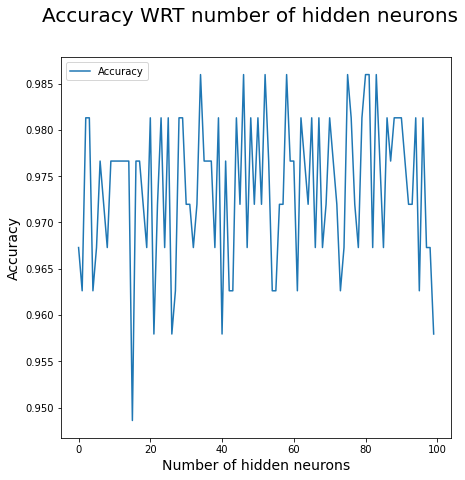

In [ ]:
#Grid search plot for optimal value of hidden neurons
accs=[]
index=[]
count=0
for grs in range(400,500):
  try:
    acc=RBFNN(data,grs)
  except:
    count=count+1
    continue
  accs.append(acc)
  index.append(grs)
print(index[np.argmax(accs)])
fig=plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
fig.suptitle('Accuracy WRT number of hidden neurons', fontsize=20)
plt.xlabel('Number of hidden neurons', fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.plot(range(0,len(accs)),accs, label = 'Accuracy')
plt.legend()
plt.show()



####Kfold process

In [19]:
def KFOLDRBFNN(data,k,nfolds,type):
    folds=split_folds(data,nfolds)
    accs=[]
    sens=[]
    specs=[]
    confmats=[]
    for fold in range(0,nfolds):
        print(fold)
        train=[]
        for fld in range(0,nfolds):
            if (fold==fld):
                test=folds[fold]
            else:
                train.append(folds[fold])
        train=np.array(train).reshape((int(data.shape[0]*(1-k)/k),data.shape[1]))
        try:
            test=np.array(test).reshape((430,data.shape[1]))
        except:
            test=np.array(test).reshape((429,data.shape[1]))
        train,test=split_train_test(split_classes(train),90)
        x_train,y_train=split_x_y(train)
        x_test,y_test=split_x_y(test)
        ks=kmeans(x_train,k)
        ks.train()  
        h= np.zeros((x_train.shape[0],(ks.k)))
        hval=np.zeros((x_test.shape[0],(ks.k)))
        for i in range(0,x_train.shape[0]):
            for j in range(0,ks.k):
                h[i,j] = activation(type,x_train[i], ks.centers[j])
        w = np.dot(np.linalg.pinv(h),y_train)
        for i in range(0,x_test.shape[0]):
            for j in range(0,ks.k):
                hval[i,j] = activation(type,x_test[i], ks.centers[j])
            predtest=np.dot(hval,w)
        for insts in range(predtest.shape[0]):
            predtest[insts,np.argmax(predtest[insts])]=1
            predtest[insts,np.argmin(predtest[insts])]=0
        
        h_test=np.rint(predtest[:,0]).reshape((test.shape[0],1))
        y_test=y_test[:,0].reshape((test.shape[0],1))
        error = (y_test-np.rint(h_test)).tolist()
        som = (y_test+np.rint(h_test)).tolist()
        FN = error.count([1.0])
        FP = error.count([-1.0])
        TN = som.count([0.0])
        TP = som.count([2.0])
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        sensitivity = TP/(TP+FN)
        specificity = TN/(FP+TN)
        conf_matrix = np.array(([TP,FP],[FN,TN]))
        accs.append(accuracy)
        sens.append(sensitivity)
        specs.append(specificity)
        confmats.append(conf_matrix)
        
    return accs,sens,specs,confmats

In [22]:
accs,sens,specs,confmats=KFOLDRBFNN(data,480,5,3)

0
1
2
3
4


In [ ]:
#For type 1 ie. linear kernel
print("Accuracies={}".format(accs))
print("Sensitivity={}".format(sens))
print("Specificity={}".format(specs))
for i in range(len(confmats)):
    print(confmats[i])

Accuracies=[0.9767441860465116, 0.9767441860465116, 0.9883720930232558, 0.9825581395348837, 0.9825581395348837]
Sensitivity=[0.9770114942528736, 0.9753086419753086, 0.9883720930232558, 0.9655172413793104, 0.9666666666666667]
Specificity=[0.9764705882352941, 0.978021978021978, 0.9883720930232558, 1.0, 1.0]
[[85  2]
 [ 2 83]]
[[79  2]
 [ 2 89]]
[[85  1]
 [ 1 85]]
[[84  0]
 [ 3 85]]
[[87  0]
 [ 3 82]]


In [21]:
#For type 2 ie. Gaussian kernel
print("Accuracies={}".format(accs))
print("Sensitivity={}".format(sens))
print("Specificity={}".format(specs))
for i in range(len(confmats)):
    print(confmats[i])

Accuracies=[0.9883720930232558, 0.9941860465116279, 0.9883720930232558, 0.9883720930232558, 0.9767441860465116]
Sensitivity=[0.9885057471264368, 0.9891304347826086, 0.9753086419753086, 1.0, 0.9555555555555556]
Specificity=[0.9882352941176471, 1.0, 1.0, 0.9782608695652174, 1.0]
[[86  1]
 [ 1 84]]
[[91  0]
 [ 1 80]]
[[79  0]
 [ 2 91]]
[[80  2]
 [ 0 90]]
[[86  0]
 [ 4 82]]


In [23]:
#For type 3 ie. Multiquadric kernel
print("Accuracies={}".format(accs))
print("Sensitivity={}".format(sens))
print("Specificity={}".format(specs))
for i in range(len(confmats)):
    print(confmats[i])

Accuracies=[0.9883720930232558, 0.9825581395348837, 0.9883720930232558, 0.9941860465116279, 0.9651162790697675]
Sensitivity=[0.9885057471264368, 0.967391304347826, 0.9876543209876543, 1.0, 0.9666666666666667]
Specificity=[0.9882352941176471, 1.0, 0.989010989010989, 0.9891304347826086, 0.9634146341463414]
[[86  1]
 [ 1 84]]
[[89  0]
 [ 3 80]]
[[80  1]
 [ 1 90]]
[[80  1]
 [ 0 91]]
[[87  3]
 [ 3 79]]
